# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

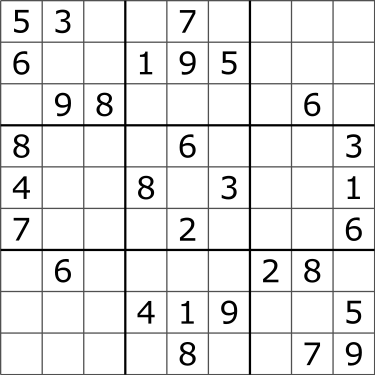

## Prepare environment

In [1]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# TODO: how to get rid of src (this is the only way VS Code resolves it)
from src.sudoku_solver.data.dataset import prepare_dataset
from src.sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from src.sudoku_solver.model.model import prepare_model
from src.sudoku_solver.model.training import prepare_callbacks
from src.sudoku_solver.model.evaluation import plot_histories

import numpy as np
import tensorflow as tf
import keras

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
#
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

E0000 00:00:1746006286.826357  129188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746006286.836641  129188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Hyperparameters

In [2]:
# We need to limit data to be able to run faster experiments
DATA_SIZE_LIMIT = 10_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

# Disk cache is slower but a must if we can't load everything into a memory
USE_DISK_CACHE = False

# Idea is to let model learn first on easy problems and then gradually increase problem difficulty
USE_CURRICULUM_LEARNING = True

# Idea is to create a layer that would penalise predictions that break Sudoku rules
#
# Note: There is no performance improvement and inference is significantly slower
USE_CONSTRAINT_LAYER = True

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk


I0000 00:00:1746006292.933306  129188 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Dataset ready.


Measuring pipeline performance...:   0%|          | 3/1000 [00:00<00:43, 22.66it/s]

Average batch fetch time is: 0.10866212844848633


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)).astype(int))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate dataset pipeline:

[[1 4 9 7 2 5 3 8 6]
 [0 0 5 3 9 8 1 4 7]
 [7 3 8 4 1 6 9 5 2]
 [8 7 3 9 6 2 4 0 5]
 [0 6 4 1 5 3 7 9 8]
 [5 9 0 0 4 7 6 2 3]
 [3 1 7 0 8 9 2 6 4]
 [4 0 2 6 3 1 5 7 9]
 [9 0 0 2 0 4 8 3 1]]
[[1 4 9 7 2 5 3 8 6]
 [6 2 5 3 9 8 1 4 7]
 [7 3 8 4 1 6 9 5 2]
 [8 7 3 9 6 2 4 1 5]
 [2 6 4 1 5 3 7 9 8]
 [5 9 1 8 4 7 6 2 3]
 [3 1 7 5 8 9 2 6 4]
 [4 8 2 6 3 1 5 7 9]
 [9 5 6 2 7 4 8 3 1]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

3

## Train model

### Prepare model

In [6]:
model = prepare_model(use_residual=USE_RESIDUAL, learning_rate=LEARNING_RATE, use_constraint_layer=USE_CONSTRAINT_LAYER, constraint_weight=10.0)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 9, 9, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]     

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
histories = []
for train_dataset in train_datasets:
    training_callbacks = prepare_callbacks()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    histories.append(history)

Epoch 1/3


I0000 00:00:1746006303.064287  129270 service.cc:148] XLA service 0x7f9fbc003b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746006303.064347  129270 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
I0000 00:00:1746006304.376761  129270 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1746006322.953752  129270 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1093 - box_constraint: 0.3176 - col_constraint: 0.2966 - loss: 12.8517 - row_constraint: 0.2920 - sudoku_constraint: 9.0622 - val_accuracy: 0.1073 - val_box_constraint: 0.0000e+00 - val_col_constraint: 0.0000e+00 - val_loss: 2.4244 - val_row_constraint: 0.0000e+00 - val_sudoku_constraint: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 906ms/step - accuracy: 0.1102 - box_constraint: 0.5542 - col_constraint: 0.5044 - loss: 20.3402 - row_constraint: 0.4844 - sudoku_constraint: 15.4303 - val_accuracy: 0.1109 - val_box_constraint: 0.0000e+00 - val_col_constraint: 0.0000e+00 - val_loss: 2.5112 - val_row_constraint: 0.0000e+00 - val_sudoku_constraint: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step - accuracy: 0.1125 - box_constraint: 0.6219 - col_constraint: 0.5396 - loss: 22.6051 - row_constraint: 0.5691 - sudoku_constraint: 17.3065 - val_accuracy: 0.1131 - val_box_constraint: 0.

### Save model

In [8]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

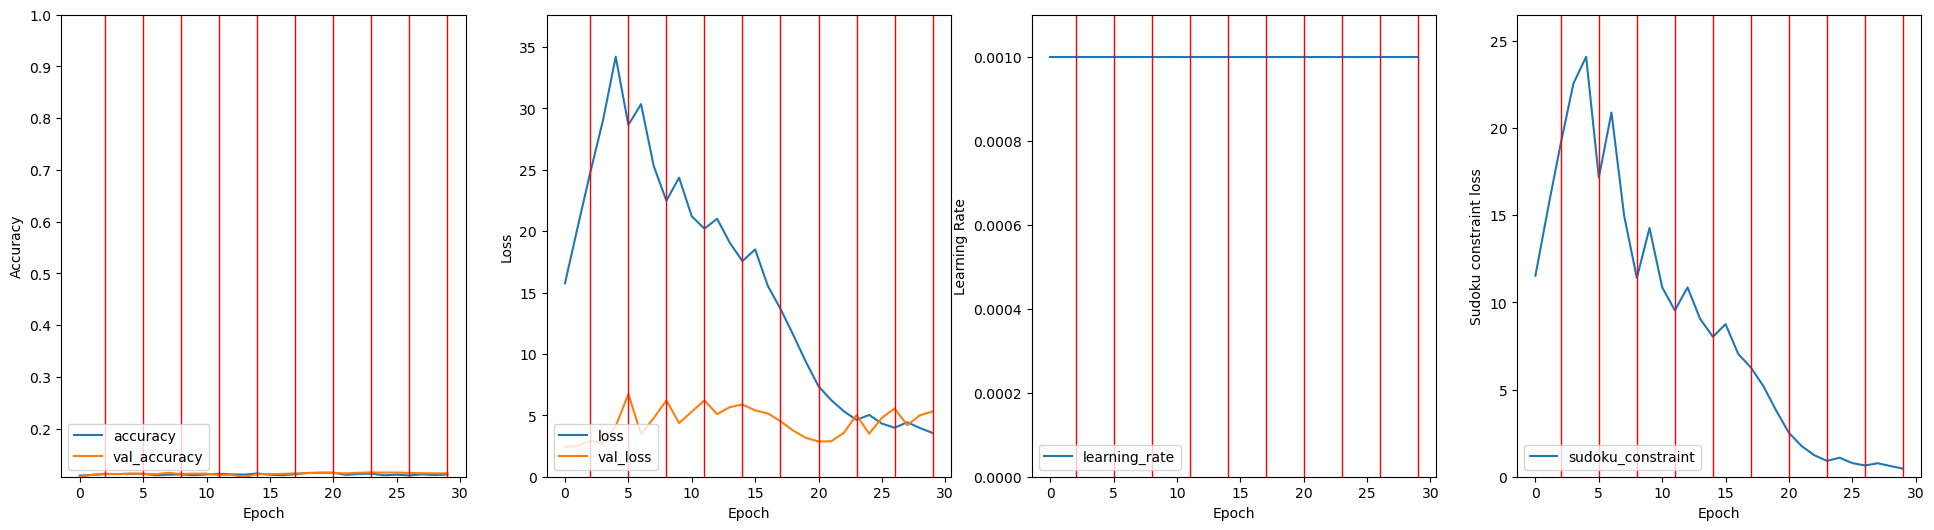

In [9]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [10]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [11]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [12]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [13]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [14]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[6 7 3 2 1 4 2 5 1]
 [9 2 5 3 9 7 8 6 4]
 [3 9 4 5 6 1 2 7 3]
 [4 8 7 8 3 5 9 1 2]
 [1 3 2 7 4 9 6 5 8]
 [5 9 8 1 6 2 7 4 1]
 [8 6 9 7 2 3 4 9 6]
 [2 5 6 4 5 1 1 3 7]
 [7 4 4 9 8 6 5 8 2]]


In [15]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1746006407.329964  129269 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1975 - box_constraint: 0.0000e+00 - col_constraint: 0.0000e+00 - loss: 4.2566 - row_constraint: 0.0000e+00 - sudoku_constraint: 0.0000e+00


In [16]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[6 7 3 2 1 8 2 5 1]
 [9 2 5 3 9 7 8 6 4]
 [3 9 4 5 6 1 2 7 3]
 [4 8 7 8 3 5 9 1 2]
 [1 3 2 7 4 9 6 5 8]
 [5 9 8 1 6 2 7 4 1]
 [8 6 9 7 2 3 4 9 6]
 [2 5 6 4 5 1 1 3 7]
 [7 4 4 9 8 6 5 8 2]]


In [17]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1481 - box_constraint: 0.0000e+00 - col_constraint: 0.0000e+00 - loss: 4.1943 - row_constraint: 0.0000e+00 - sudoku_constraint: 0.0000e+00


0.14814814925193787

### Evaluate on different difficulties

In [18]:
for index, train_dataset in enumerate(train_datasets):
    loss, accuracy, *rest = model.evaluate(train_dataset, verbose=0)
    print(f"Difficulty {index + 1}: loss={loss}, accuracy={accuracy}")
    
    for X_batch, _ in train_dataset.take(1):
        avg_non_zero_count = tf.reduce_mean(tf.math.count_nonzero((X_batch + 0.5) * 9, axis=(1, 2)))
        print(f"Average non-zero numbers in puzzle in one batch: {int(avg_non_zero_count)}\n")


Difficulty 1: loss=4.153961658477783, accuracy=0.11259002238512039
Average non-zero numbers in puzzle in one batch: 70

Difficulty 2: loss=4.211996078491211, accuracy=0.11130400747060776
Average non-zero numbers in puzzle in one batch: 47

Difficulty 3: loss=4.2174530029296875, accuracy=0.10968043655157089
Average non-zero numbers in puzzle in one batch: 44

Difficulty 4: loss=4.211782455444336, accuracy=0.11283115297555923
Average non-zero numbers in puzzle in one batch: 41

Difficulty 5: loss=4.2113237380981445, accuracy=0.11064493656158447
Average non-zero numbers in puzzle in one batch: 40

Difficulty 6: loss=4.215872287750244, accuracy=0.11125578731298447
Average non-zero numbers in puzzle in one batch: 38

Difficulty 7: loss=4.211711406707764, accuracy=0.11432614177465439
Average non-zero numbers in puzzle in one batch: 37

Difficulty 8: loss=4.215623378753662, accuracy=0.11170589178800583
Average non-zero numbers in puzzle in one batch: 35

Difficulty 9: loss=4.21042537689209, a

### Evaluate test set performance

In [19]:
loss, accuracy, *rest = model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.1138 - box_constraint: 0.0000e+00 - col_constraint: 0.0000e+00 - loss: 4.2151 - row_constraint: 0.0000e+00 - sudoku_constraint: 0.0000e+00


In [20]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.11381173133850098 and loss: 4.215113639831543


The End